# Lab Assignment Four: Multi-Layer Perceptron

## 1.Load, Split, and Balance

- [.5 points] Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the variables until asked to do so.  Remove any observations that having missing data. Encode any string data as integers for now. 
- [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing.
- [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

In [39]:
#import the lib needed 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
import sys

%matplotlib inline
%config InlineBackend.figure_format='retina'

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)

numpy version is: 1.19.2
pandas version is: 1.1.3


In [40]:
df = pd.read_csv('./data/acs2017_census_tract_data.csv')

pd.set_option('display.max_columns', None)
df.describe(include='all')

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,7.400100e+04,74001,74001,74001.000000,74001.000000,74001.000000,73305.000000,73305.000000,73305.00000,73305.000000,73305.000000,73305.000000,74001.000000,72885.000000,72885.000000,73256.000000,73256.000000,73159.000000,72891.000000,73190.000000,73190.000000,73190.000000,73190.000000,73190.000000,73200.000000,73200.000000,73200.000000,73200.000000,73200.000000,73200.000000,73055.000000,74001.000000,73190.000000,73190.000000,73190.000000,73190.000000,73191.000000
unique,NaN,52,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,California,Los Angeles County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8057,2346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.839113e+10,NaN,NaN,4384.716017,2157.710707,2227.005311,17.265444,61.309043,13.28910,0.734047,4.753691,0.147341,3102.885961,61086.829265,9697.465747,30651.804194,4270.174225,16.118186,21.155872,35.559478,18.874446,23.427724,9.239350,12.899281,75.698005,9.308369,5.395186,3.042825,1.894605,4.661466,26.056594,2049.152052,79.494222,14.163342,6.171484,0.171164,7.246738
std,1.647593e+10,NaN,NaN,2228.936729,1120.560504,1146.240218,23.073811,30.634461,21.60118,4.554247,8.999888,1.029250,1542.245024,30516.098180,6154.669518,16126.937143,3148.049041,12.691045,18.645759,15.144984,8.137261,5.806091,6.031393,7.712496,15.292660,5.222494,11.689470,5.805753,2.549374,4.014940,7.124524,1138.865457,8.126383,7.328680,3.932364,0.456580,5.227624
min,1.001020e+09,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2692.000000,728.000000,32.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.303901e+10,NaN,NaN,2903.000000,1416.000000,1465.000000,2.600000,38.000000,0.80000,0.000000,0.200000,0.000000,2061.000000,40357.000000,5735.000000,20556.750000,2503.000000,6.900000,6.200000,24.700000,13.300000,19.700000,5.000000,7.100000,72.200000,5.700000,0.000000,0.400000,0.400000,2.000000,21.100000,1276.000000,75.200000,9.300000,3.500000,0.000000,3.900000
50%,2.804700e+10,NaN,NaN,4105.000000,2007.000000,2082.000000,7.400000,70.400000,3.80000,0.000000,1.500000,0.000000,2905.000000,54375.000000,8267.000000,27215.500000,3404.000000,12.600000,16.300000,33.300000,17.700000,23.200000,8.300000,11.800000,79.900000,8.500000,1.000000,1.400000,1.200000,3.800000,25.400000,1895.000000,80.600000,13.000000,5.500000,0.000000,6.000000
75%,4.200341e+10,NaN,NaN,5506.000000,2707.000000,2803.000000,21.100000,87.700000,14.60000,0.400000,5.000000,0.000000,3906.000000,74659.000000,11913.000000,36408.250000,4968.250000,21.800000,31.600000,44.900000,23.300000,26.900000,12.500000,17.500000,84.900000,11.900000,4.600000,3.300000,2.500000,6.300000,30.300000,2635.000000,85.000000,17.600000,8.000000,0.000000,9.000000


In [41]:
df.dtypes

TractId               int64
State                object
County               object
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          

### There are two columns of data required to transform into integers. I use LabelEncoder to encode the string data of State and County to integers and add them into the dataframe in the column "State_C" and "County_C" respectively.

In [42]:
df['State_C'] = LabelEncoder().fit_transform(df['State'])
df['County_C'] = LabelEncoder().fit_transform(df['County'])

df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,State_C,County_C
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826.0,14560.0,33018.0,6294.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6,0,89
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287.0,3819.0,18996.0,2453.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4,0,89
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806.0,9496.0,21236.0,2562.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7,0,89
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895.0,4369.0,28068.0,3190.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1,0,89
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143.0,14424.0,36905.0,10706.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3,0,89


### To check if there are NA in this dataset

In [43]:
print(df.isna().sum())

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
State_C                0
County_C               0
dtype: int64


In [44]:
# drop the rows contained NA data. 
df = df.dropna()
print(df.isna().sum())

TractId             0
State               0
County              0
TotalPop            0
Men                 0
Women               0
Hispanic            0
White               0
Black               0
Native              0
Asian               0
Pacific             0
VotingAgeCitizen    0
Income              0
IncomeErr           0
IncomePerCap        0
IncomePerCapErr     0
Poverty             0
ChildPoverty        0
Professional        0
Service             0
Office              0
Construction        0
Production          0
Drive               0
Carpool             0
Transit             0
Walk                0
OtherTransp         0
WorkAtHome          0
MeanCommute         0
Employed            0
PrivateWork         0
PublicWork          0
SelfEmployed        0
FamilyWork          0
Unemployment        0
State_C             0
County_C            0
dtype: int64


### I divide the column "ChildPoverty" into 4 balanced classes by quantile and set it up as column "ChildPoverty_C" in the dataframe.

In [45]:
df['ChildPoverty_C'] = pd.qcut(df.Production,[0,.25,.5,.75,1],labels=(0,1,2,3))
np.bincount(df['ChildPoverty_C'])

array([18509, 17926, 18256, 18027])

In [46]:
df1 = df.drop(['State','County','ChildPoverty'],axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   TractId           72718 non-null  int64   
 1   TotalPop          72718 non-null  int64   
 2   Men               72718 non-null  int64   
 3   Women             72718 non-null  int64   
 4   Hispanic          72718 non-null  float64 
 5   White             72718 non-null  float64 
 6   Black             72718 non-null  float64 
 7   Native            72718 non-null  float64 
 8   Asian             72718 non-null  float64 
 9   Pacific           72718 non-null  float64 
 10  VotingAgeCitizen  72718 non-null  int64   
 11  Income            72718 non-null  float64 
 12  IncomeErr         72718 non-null  float64 
 13  IncomePerCap      72718 non-null  float64 
 14  IncomePerCapErr   72718 non-null  float64 
 15  Poverty           72718 non-null  float64 
 16  Professional      7271

In [47]:
y = np.array(df1['ChildPoverty_C'])
df1.drop(['ChildPoverty_C'],axis=1,inplace=True)
X = np.array(df1)

In [48]:
print('X.shape:',X.shape)
print('y.shape:',y.shape)

n_features = X.shape[1]
n_samples = X.shape[0]

print('n_samples:',n_samples)
print('n_features',n_features)

X.shape: (72718, 36)
y.shape: (72718,)
n_samples: 72718
n_features 36


## Split the dataset into 80% for training and 20% for testing.
I have did the dataset balancing first, so here I did not do it respectively for training and testing set.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8)


In [50]:
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (58174, 36)
X_test (14544, 36)
y_train (58174,)
y_test (14544,)


## Should balancing of the dataset be done for both the training and testing set?

It's not necessary to do balancing on the testing dataset because testing set is used for evaluating learning capability of the model. It's critical to have a balanced dataset for training set so that the model could maximize its possibility to learn plenty of details from the training data.

## 2.Pre-processing

There are a number of version of the two layer perceptron covered in class. When using the example two layer network from class be sure that you use: (1) vectorized computation, (2) mini-batching, and (3) proper Glorot initialization, at a minimum.  

- [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 
- [.5 points] Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  
- [.5 points] Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 
- [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
    - Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

In [51]:
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 l2=0.0, epochs=500, eta=0.001, random_state=None, onehot=True, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = l2
        self.epochs = epochs
        self.eta = eta
        self.onehot = onehot
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self,y):
        """Encode labels into one-hot representation"""
        if self.onehot:
            return pd.get_dummies(y).values.T
        else:
            return y[np.newaxis]

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def graph_loss_function(self):
        cost_avgs = [np.mean(x) for x in self.cost_]
        plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.tight_layout()
        plt.show()

In [52]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)

        # print('A1.shape: ',A1.shape)
        # print('W1.shape: ',W1.shape)
        # print('Z1.shape: ',Z1.shape)
        # print('A2.shape: ',A2.shape)
        # print('W2.shape: ',W2.shape)
        # print('Z2.shape: ',Z2.shape)
        # print('A3.shape: ',A3.shape)

        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)


### 2.1 Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

In [53]:
params = dict(n_hidden=300, 
              l2=0.0, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=1e-2,  # learning rate
              random_state=1,
              onehot=False,
              alpha=1e-2,
              decrease_const=0.1,
              minibatches=len(X_train)/32,
              shuffle=True
              )

Epoch: 500/500
Accuracy: 0.25563806380638066


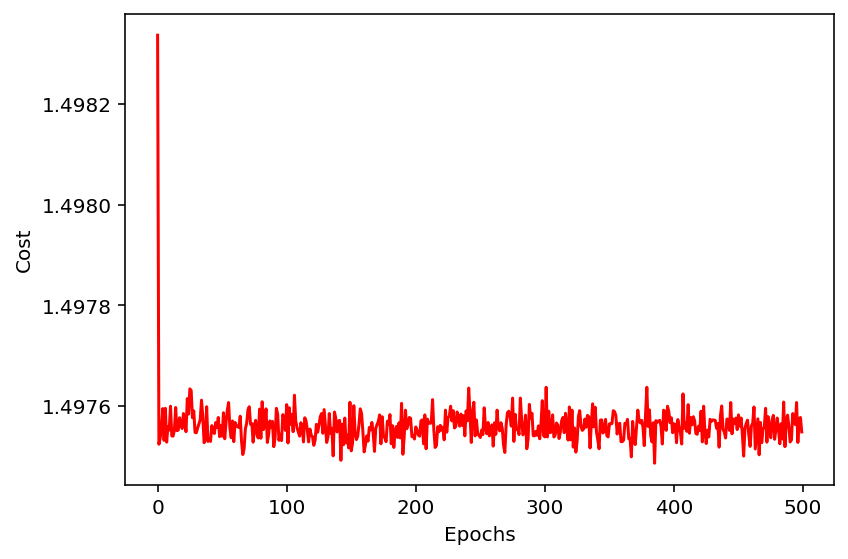

CPU times: user 33min 30s, sys: 4min 27s, total: 37min 57s
Wall time: 4min 53s


In [54]:
%%time
nn1 = TwoLayerPerceptron(**params)
nn1.fit(X_train, y_train, print_progress=1)
print()
print('Accuracy:',accuracy_score(y_test,nn1.predict(X_test)))
nn1.graph_loss_function()

### 2.2 Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

Epoch: 300/300
Accuracy: 0.25563806380638066


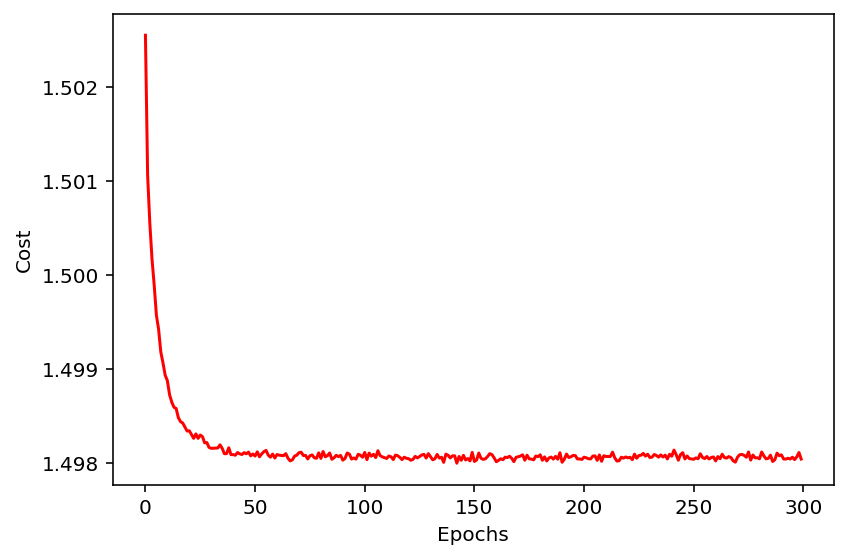

CPU times: user 20min 5s, sys: 2min 39s, total: 22min 45s
Wall time: 2min 55s


In [55]:
%%time
params['epochs'] = 300
params['l2']=1e-2
nn2 = TwoLayerPerceptron(**params)
nn2.fit(X_train, y_train, print_progress=1)
print()
print('Accuracy:',accuracy_score(y_test,nn2.predict(X_test)))
nn2.graph_loss_function()

### 2.3 Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

Epoch: 300/300
Accuracy: 0.24456820682068206


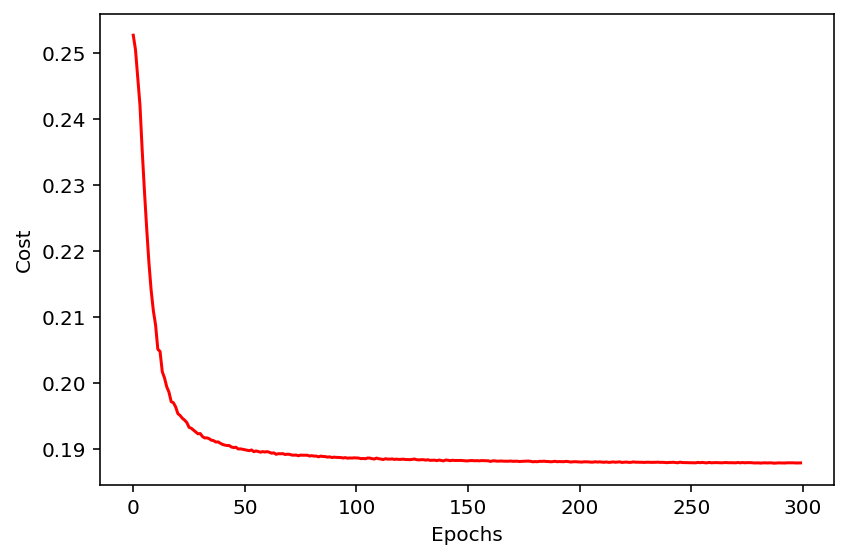

CPU times: user 22min 47s, sys: 2min 51s, total: 25min 38s
Wall time: 3min 17s


In [56]:
%%time
params['epochs'] = 300
params['onehot']=True
nn3 = TwoLayerPerceptron(**params)
nn3.fit(X_train, y_train, print_progress=1)
print()
print('Accuracy:',accuracy_score(y_test,nn3.predict(X_test)))
nn3.graph_loss_function()

### 2.4 Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.(Need to use statistical method)

## 3.Modeling

- [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.
- [1 points] Repeat the previous step, adding support for a fourth layer.
- [1 points] Repeat the previous step, adding support for a fifth layer. 
- [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 


In [57]:
class ThreeLayerPerceptron(TwoLayerPerceptron):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W2[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W3[:,:1] = 0
        
        return W1, W2

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2)+ np.mean(W3[:,1:]**2))


    def _feedforward(self, X, W1, W2, W3):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A2
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3 , Z3, A4


    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred


In [58]:
class FourLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A2
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3,Z3, A4, Z4, A5

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred


In [59]:
class FiveLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A2
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3,Z3, A4, Z4, A5, Z5, A6

## 4.Exceptional Work

One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance